In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocess as mp
import glob
import time
from tqdm import tqdm
import os
import sys
import pandas as pd
from eumap.misc import find_files, nan_percentile, GoogleSheet, ttprint
from eumap.raster import read_rasters, save_rasters
from eumap.mapper import SpaceOverlay
import geopandas as gpd
from pathlib import Path
import rasterio
import pyproj
from shapely.geometry import Point
from eumap.mapper import LandMapper

import warnings

import matplotlib
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor

import joblib
import pickle

folder = '/mnt/inca/soc_eu_model'
df = pd.read_csv(f'{folder}/data/005.0_train.pnts_oc.csv',low_memory=False)

# target
tgt = 'oc_log1p'

# covariates
meta_info = ['id','lat','lon','time','ref','nuts0','geometry','tile_id']
meta_prop = ['oc','ph_h2o','ph_cacl2','bulk_density','clay','silt','sand','caco3','N','K','P','CEC','EC']
meta_qa = [i+'_qa' for i in meta_prop]
meta = meta_info + meta_prop + meta_qa + [tgt]
covs = [i for i in df.columns if i not in meta]
df = df.dropna(subset=covs,how='any')

# read in covariates selected with rfecv 
with open(f'{folder}/SOC-EU/features/001_selected.covar_rfecv.txt', 'r') as file:
    lines = file.readlines()
covs_rfecv = [line.strip() for line in lines]

# read in covariates selected with rank.freq
with open(f'{folder}/SOC-EU/features/002_selected.covar_rank.freq.txt', 'r') as file:
    lines = file.readlines()
covs_rank = [line.strip() for line in lines]


/home/opengeohub/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### Using 5 fold spatial blocking CV to examine which selected feature set behave best

In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from mapie.regression import MapieRegressor
from sklearn.ensemble import RandomForestRegressor
from tool_kit import calc_ccc

def calculate_coverage(y_true, lower_bound, upper_bound):
    return np.mean((y_true >= lower_bound) & (y_true <= upper_bound))

def features_cv(data,covs,tgt,name,spatial_cv_column = 'tile_id', n_splits=5, alpha=0.2):
    rmse_scores = []
    r2_scores = []
    ccc_scores = []
    y_actual_all = np.array([])
    y_pred_all = np.array([])
    y_pis_all = []
    
    gkf = GroupKFold(n_splits=n_splits)
    k = 0

    for train_index, test_index in gkf.split(data, data[tgt], groups=data[spatial_cv_column]):
        
        X_train, X_test = data.iloc[train_index][covs], data.iloc[test_index][covs]
        y_train, y_test = data.iloc[train_index][tgt], data.iloc[test_index][tgt]

        model = RandomForestRegressor(n_estimators=800, max_depth=30, max_features="sqrt", min_samples_leaf=4,
                                       min_samples_split=2, random_state=0, n_jobs=80)
        mapie = MapieRegressor(model, method="plus", cv=5) # this cv is to compute the conformal scores
        ttprint(f'iter {k}, size: {len(X_train)}')
        k = k+1
        
        mapie.fit(X_train, y_train)
        y_pred, y_pis = mapie.predict(X_test, alpha=alpha) 

        # Collect predictions and intervals
        y_actual_all = np.append(y_actual_all, y_test)
        y_pred_all = np.append(y_pred_all, y_pred)
        y_pis_all.append(y_pis)

    y_pis_all = np.concatenate(y_pis_all, axis=0)
    return y_actual_all, y_pred_all, y_pis_all

def examine_features(y_actual_all, y_pred_all, y_pis_all, name, cov_len, alpha=0.2):
    y_actual_all = np.expm1(y_actual_all)
    y_pred_all = np.expm1(y_pred_all)
    y_pis_all = np.expm1(y_pis_all)
    
    # get scores
    rmse = mean_squared_error(y_actual_all, y_pred_all, squared=False)
    r2 = r2_score(y_actual_all, y_pred_all)
    ccc = calc_ccc(y_actual_all, y_pred_all)
    
    coverage_score = calculate_coverage(y_actual_all, y_pis_all[:, 0, :], y_pis_all[:, 1, :])
    coverage_interval = np.mean(y_pis_all[:, 1, :] - y_pis_all[:, 0, :])
    
    # Sort y_actual_all and corresponding intervals and predictions
    sorted_indices = np.argsort(y_actual_all)
    y_actual_sorted = y_actual_all[sorted_indices]
    y_pred_sorted = y_pred_all[sorted_indices]
    y_pis_sorted = y_pis_all[sorted_indices, :, :]

    fig = plt.figure(figsize = (9,9))
    fig.suptitle(f"Feature set: {name}, {cov_len} features", fontsize=20, fontweight='bold')
    plt.title(f'R2={r2:.3f}, rmse={rmse:.3f}, ccc={ccc:.3f}\n coverage score:{coverage_score:.3f}, mean coverage interval:{coverage_interval:.3f}', fontsize=16)
#     plt.scatter(y_actual_all, y_pred_all, alpha=0.5, label='Predicted vs Actual')
    plt.fill_between(y_actual_sorted, y_pis_sorted[:, 0, 0], y_pis_sorted[:, 1, 0], color='blue', alpha=0.2, label='Prediction Interval 10% - 90%')
    plt.hexbin(y_actual_sorted, y_pred_sorted, gridsize=(100, 100) , cmap = 'plasma_r', mincnt=1, vmax = 100)#, xscale =25, yscale = 25)
#     plt.plot([min(y_actual_all), max(y_actual_all)], [min(y_actual_all), max(y_actual_all)], color='red', linestyle='--', label='1:1 Line')
    plt.plot([0, 6.2], [0, 6.2], "-k", alpha = .5)
    plt.xlabel('true oc-log1p', fontsize=16)
    plt.ylabel('predicted oc-log1p', fontsize=16)
    plt.legend()
    plt.show()
    return [rmse, r2, ccc, coverage_score, coverage_interval]

df_score = pd.DataFrame(columns=['rmse','r2','ccc','PICP','prediction interval width'], index=['full','rfecv','rank frequency'])


[22:19:39] iter 0, size: 103136
[22:23:20] iter 1, size: 103136
[22:26:56] iter 2, size: 103136
[22:30:37] iter 3, size: 103136
[22:34:08] iter 4, size: 103136


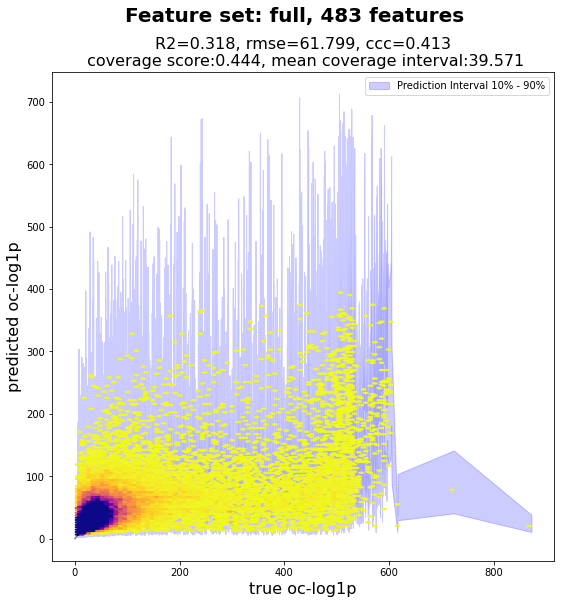

,rmse,r2,ccc,PICP,prediction interval width
full,61.798723,0.318006,0.412632,0.443973,39.570686
rfecv,NaN,NaN,NaN,NaN,NaN
rank.freq,NaN,NaN,NaN,NaN,NaN


In [3]:
# full covs
name = 'full'
y_actual, y_pre, y_pis = features_cv(dff, covs, tgt, name)

scores = examine_features(y_actual, y_pre, y_pis, name, len(covs))
df_score.loc[name] = scores
df_score

[22:37:56] iter 0, size: 103136
[22:41:02] iter 1, size: 103136
[22:44:17] iter 2, size: 103136
[22:47:31] iter 3, size: 103136
[22:50:51] iter 4, size: 103136


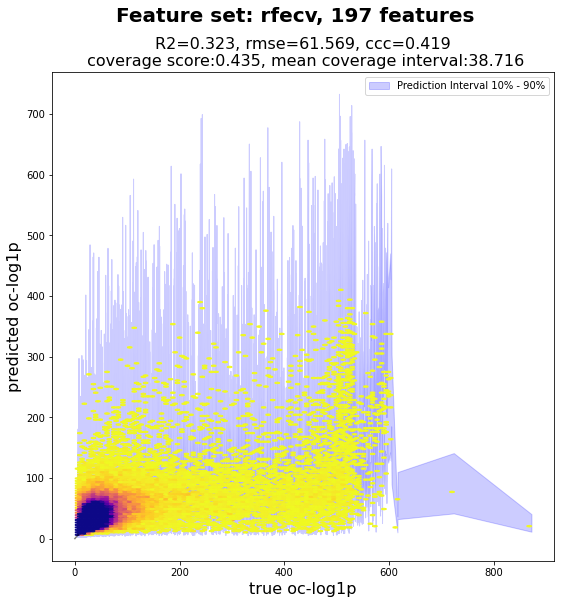

,rmse,r2,ccc,PICP,prediction interval width
full,61.798723,0.318006,0.412632,0.443973,39.570686
rfecv,61.569252,0.323061,0.419076,0.434814,38.716283
rank.freq,NaN,NaN,NaN,NaN,NaN


In [4]:
name = 'rfecv'
y_actual, y_pre, y_pis = features_cv(dff, covs_rfecv, tgt, name)

scores = examine_features(y_actual, y_pre, y_pis, name, len(covs_rfecv))
df_score.loc[name] = scores
df_score

In [6]:
name = 'rank freqency'
y_actual, y_pre, y_pis = features_cv(df, covs_rank, tgt, name)

scores = examine_features(y_actual, y_pre, y_pis, name, len(covs_rank))
df_score.loc[name] = scores
df_score

[10:15:51] iter 0, size: 76653


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_67539/1695612332.py", line 2, in <module>
    y_actual, y_pre, y_pis = features_cv(df, covs_rank, tgt, name)
  File "/tmp/ipykernel_67539/128430878.py", line 34, in features_cv
    mapie.fit(X_train, y_train)
  File "/home/opengeohub/.local/lib/python3.8/site-packages/mapie/regression/regression.py", line 532, in fit
    self.estimator_ = self.estimator_.fit(
  File "/home/opengeohub/.local/lib/python3.8/site-packages/mapie/estimator/estimator.py", line 459, in fit
    single_estimator_ = self._fit_oof_estimator(
  File "/home/opengeohub/.local/lib/python3.8/site-packages/mapie/estimator/estimator.py", line 222, in _fit_oof_estimator
    estimator = fit_estimator(
  File "/home/opengeohub/.local/lib/python3.8/site-packages/mapie/utils.py", line 131, in fit_estimator
    es

TypeError: object of type 'NoneType' has no len()

In [10]:
df_score = df_score.drop('rank.freq')
df_score

,rmse,r2,ccc,PICP,prediction interval width
full,61.798723,0.318006,0.412632,0.443973,39.570686
rfecv,61.569252,0.323061,0.419076,0.434814,38.716283
rank freqency,61.196099,0.331242,0.429253,0.429057,38.318766


In [11]:
df_score['feature_num'] = [len(covs),len(covs_rfecv),len(covs_rank)]
df_score

,rmse,r2,ccc,PICP,prediction interval width,feature_num
full,61.798723,0.318006,0.412632,0.443973,39.570686,483
rfecv,61.569252,0.323061,0.419076,0.434814,38.716283,197
rank freqency,61.196099,0.331242,0.429253,0.429057,38.318766,134


In [13]:
df_score.to_csv(f'{folder}/SOC-EU/features/003_scores.covs_comparison.csv')